# Question 1

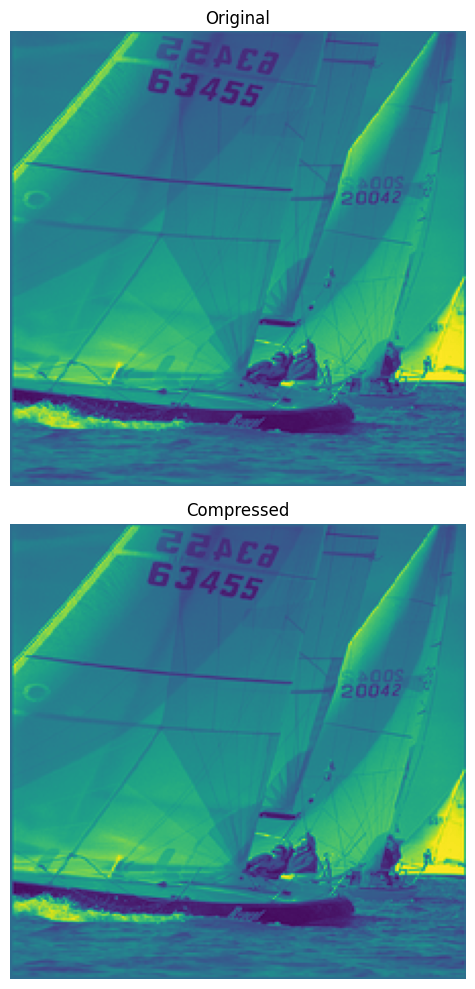

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(directory, target_size=(224, 224), grayscale=True):
    images = []
    filenames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".bmp"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)

            if grayscale:
                img = img.convert('L')  # Convert to grayscale

            img = img.resize(target_size, Image.LANCZOS)

            img_array = np.array(img)
            if grayscale:
                img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension for grayscale

            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames


dataset_path=r"/content/drive/MyDrive/A2_DATASET_Q1"
target_size = (224, 224)


ref_imgs, ref_filenames = load_and_preprocess_images(os.path.join(dataset_path, "refimgs"), target_size)

# Load compressed images
compressed_imgs = []
compressed_filenames = []
for qf in range(10, 100, 10):
    qf_imgs, qf_filenames = load_and_preprocess_images(os.path.join(dataset_path, f"qf{qf}"), target_size)
    compressed_imgs.extend(qf_imgs)
    compressed_filenames.extend([f"qf{qf}_{filename}" for filename in qf_filenames])

compressed_imgs = np.array(compressed_imgs)


ref_imgs = ref_imgs.astype('float32') / 255.0
compressed_imgs = compressed_imgs.astype('float32') / 255.0

# Create pairs of compressed and reference images
X = []
y = []
for i, comp_filename in enumerate(compressed_filenames):
    ref_filename = comp_filename.split('_', 1)[1]  # Remove the 'qfXX_' prefix
    if ref_filename in ref_filenames:
        ref_index = ref_filenames.index(ref_filename)
        X.append(compressed_imgs[i])
        y.append(ref_imgs[ref_index])

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



import matplotlib.pyplot as plt

def plot_samples(original, compressed, num_samples=1):
    for i in range(num_samples):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

        ax1.imshow(original[20])
        ax1.set_title("Original")
        ax1.axis('off')

        ax2.imshow(compressed[20])
        ax2.set_title("Compressed")
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

plot_samples(y_train, X_train)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Convert data to PyTorch tensors with the correct shape (channels, height, width)
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)  # Transpose to (batch, channels, height, width)
y_train_tensor = torch.tensor(y_train.transpose(0, 3, 1, 2), dtype=torch.float32)

# Similarly for the test data
X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.transpose(0, 3, 1, 2), dtype=torch.float32)

# Create a DataLoader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = data.DataLoader(test_dataset, batch_size=16, shuffle=False)



import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torch
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# PSNR Calculation
def calculate_psnr(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    psnr = peak_signal_noise_ratio(original, reconstructed, data_range=1.0)  # Assuming normalized [0, 1]
    return psnr

# SSIM Calculation
def calculate_ssim(original, reconstructed):
    original = original.squeeze(0).cpu().numpy()
    reconstructed = reconstructed.squeeze(0).cpu().numpy()
    ssim = structural_similarity(original, reconstructed, data_range=1.0)
    return ssim

# MSE Calculation
def calculate_mse(original, reconstructed):
    return F.mse_loss(original, reconstructed).item()

# Function to calculate metrics for multiple images
def evaluate_metrics(original_imgs, reconstructed_imgs):
    total_psnr = 0
    total_ssim = 0
    total_mse = 0
    num_images = original_imgs.shape[0]

    for i in range(num_images):
        original = original_imgs[i]
        reconstructed = reconstructed_imgs[i]

        # Compute PSNR
        psnr = calculate_psnr(original, reconstructed)
        total_psnr += psnr

        # Compute SSIM
        ssim = calculate_ssim(original, reconstructed)
        total_ssim += ssim

        # Compute MSE
        mse = calculate_mse(original, reconstructed)
        total_mse += mse

    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images
    avg_mse = total_mse / num_images

    return avg_psnr, avg_ssim, avg_mse

# Plot a few examples with PSNR and SSIM
def plot_reconstructed_images(original_imgs_np, reconstructed_imgs_np, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Original
        axes[0, i].imshow(original_imgs_np[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Reconstructed
        axes[1, i].imshow(reconstructed_imgs_np[i], cmap='gray')
        psnr = calculate_psnr(torch.tensor(original_imgs_np[i]), torch.tensor(reconstructed_imgs_np[i]))
        ssim = calculate_ssim(torch.tensor(original_imgs_np[i]), torch.tensor(reconstructed_imgs_np[i]))
        axes[1, i].set_title(f"Reconstructed\nPSNR: {psnr:.2f}, SSIM: {ssim:.2f}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Residual Block for better gradient flow
class ResidualBlockwd(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlockwd, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Residual connection
        out = self.relu(out)
        return out

# Complex autoencoder with skip connections, residual blocks, and dropout
class AdvancedAutoencoderwd(nn.Module):
    def __init__(self):
        super(AdvancedAutoencoderwd, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample to 112x112
            nn.Dropout(0.3)  # Dropout layer
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample to 56x56
            nn.Dropout(0.3)  # Dropout layer
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample to 28x28
            nn.Dropout(0.3)  # Dropout layer
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample to 14x14
            nn.Dropout(0.3)  # Dropout layer
        )

        # Residual blocks for improved gradient flow
        self.res_block = ResidualBlockwd(512)

        # Decoder with skip connections
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upsample to 28x28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout layer
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upsample to 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout layer
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upsample to 112x112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  # Dropout layer
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),     # Upsample to 224x224
            nn.Sigmoid()  # Output between 0 and 1 for image reconstruction
        )

    def forward(self, x):
        # Encoder with skip connections
        enc1 = self.encoder1(x)  # 64x112x112
        enc2 = self.encoder2(enc1)  # 128x56x56
        enc3 = self.encoder3(enc2)  # 256x28x28
        enc4 = self.encoder4(enc3)  # 512x14x14

        # Residual block
        enc4_res = self.res_block(enc4)

        # Decoder with skip connections
        dec4 = self.decoder4(enc4_res + enc4)  # Skip connection: 512x14x14 -> 256x28x28
        dec3 = self.decoder3(dec4 + enc3)      # Skip connection: 256x28x28 -> 128x56x56
        dec2 = self.decoder2(dec3 + enc2)      # Skip connection: 128x56x56 -> 64x112x112
        dec1 = self.decoder1(dec2 + enc1)      # Skip connection: 64x112x112 -> 1x224x224

        return dec1

# Train the model
def train_advanced_modelwd(model, train_loader, num_epochs=20, patience=5):
    # Check if CUDA is available and use GPU if possible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the device

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Use ReduceLROnPlateau to reduce the learning rate when a plateau is reached
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, targets = data

            # Move data to the device
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

        # Learning rate scheduling
        scheduler.step(avg_loss)

        # Early stopping if no improvement in loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

    return inputs.detach(), outputs.detach()  # Return some original and reconstructed images


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10, Loss: 0.080426
Epoch 2/10, Loss: 0.050683
Epoch 3/10, Loss: 0.043192
Epoch 4/10, Loss: 0.038732
Epoch 5/10, Loss: 0.034577
Epoch 6/10, Loss: 0.031105
Epoch 7/10, Loss: 0.029296
Epoch 8/10, Loss: 0.026636
Epoch 9/10, Loss: 0.024978
Epoch 10/10, Loss: 0.023208
Average PSNR: 16.5529
Average SSIM: 0.3776
Average MSE: 0.0228


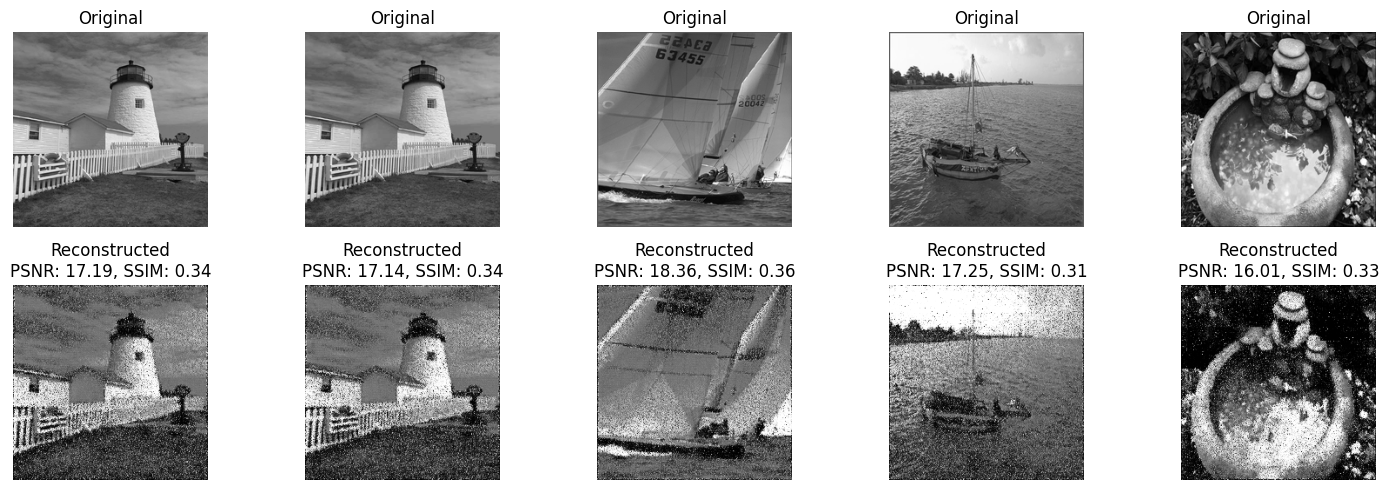

In [4]:
# Define the model, loss function, optimizer, and learning rate scheduler
model = AdvancedAutoencoderwd()

original_imgs, reconstructed_imgs = train_advanced_modelwd(model, train_loader, num_epochs=10)
# Convert to numpy arrays (remove channel dimensions)
original_imgs_np = original_imgs.squeeze(1).cpu().numpy()
reconstructed_imgs_np = reconstructed_imgs.squeeze(1).cpu().numpy()

# Evaluate the metrics
avg_psnr, avg_ssim, avg_mse = evaluate_metrics(original_imgs, reconstructed_imgs)

# Print the average PSNR, SSIM, and MSE
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average MSE: {avg_mse:.4f}")

# Visualize some original vs reconstructed images with metrics
plot_reconstructed_images(original_imgs_np, reconstructed_imgs_np, num_images=5)


##### FINDINGS

The metrics obtained after 10 epochs of training are:
Average PSNR: 16.55
Average SSIM: 0.3776
Average MSE: 0.0228

# Question 2


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 640x640 1 person, 479.4ms
Speed: 3.5ms preprocess, 479.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 bounding boxes.
Bounding Box Coordinates: (-17007, -65415, 253127, 324788)


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Epoch [10/100], Loss: 1.2612
Epoch [20/100], Loss: 0.8305
Epoch [30/100], Loss: 0.6296
Epoch [40/100], Loss: 0.4957
Epoch [50/100], Loss: 0.4105
Epoch [60/100], Loss: 0.3515
Epoch [70/100], Loss: 0.3059
Epoch [80/100], Loss: 0.2690
Epoch [90/100], Loss: 0.2383
Epoch [100/100], Loss: 0.2123


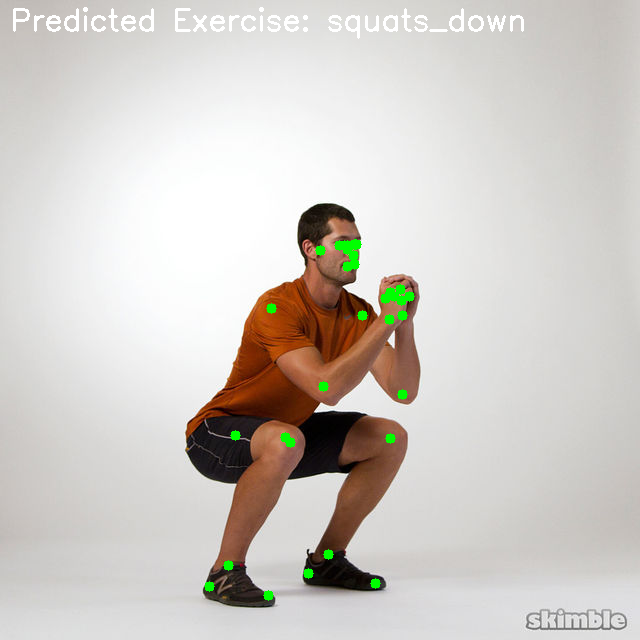

In [ ]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from mediapipe import solutions as mp_solutions
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Image Acquisition
def acquire_image(image_path):
    return cv2.imread(image_path)

# Step 2: Bounding Box Detection Using YOLO
def detect_person(image):
    model = YOLO('yolov5s.pt')  # Load YOLOv5s model
    results = model(image)      # Perform detection
    boxes = results[0].boxes.data.cpu().numpy()  # Extract boxes data
    return image, boxes

def get_bbox_from_yolo_box(box, image_width, image_height):
    """Converts YOLO box (center_x, center_y, width, height) to pixel coordinates (x1, y1, x2, y2)."""
    x_center, y_center, width, height = box[:4]

    # Convert normalized coordinates to pixel values
    x1 = int((x_center - width / 2) * image_width)
    y1 = int((y_center - height / 2) * image_height)
    x2 = int((x_center + width / 2) * image_width)
    y2 = int((y_center + height / 2) * image_height)

    return x1, y1, x2, y2

# Step 3: 3D Pose Estimation Using MediaPipe
def estimate_pose(image, bbox):
    mp_pose = mp_solutions.pose
    pose_estimator = mp_pose.Pose(static_image_mode=True, model_complexity=2)

    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    results = pose_estimator.process(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

    if results.pose_landmarks:
        return [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
    return []

# Step 4: Visualize Predicted Landmarks and Label
def visualize_predictions(original_image, landmarks_3d, predicted_label, bbox):
    vis_image = original_image.copy()
    x1, y1, x2, y2 = bbox
    cv2.rectangle(vis_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw bounding box

    for x, y, z in landmarks_3d:
        x_pixel = int(x * original_image.shape[1])
        y_pixel = int(y * original_image.shape[0])
        cv2.circle(vis_image, (x_pixel, y_pixel), 5, (0, 255, 0), -1)  # Draw landmarks

    cv2.putText(vis_image, f'Predicted Exercise: {predicted_label}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2_imshow(vis_image)

# Step 5: Custom CNN for Exercise Classification
class CustomCNN(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Function to classify exercise based on 3D landmarks
def classify_exercise(landmarks_3d, model, label_encoder):
    if not landmarks_3d:
        return "No landmarks detected."

    landmarks_array = np.array(landmarks_3d).flatten()
    expected_size = 115
    padded_array = np.pad(landmarks_array, (0, max(0, expected_size - len(landmarks_array))), 'constant')

    landmarks_tensor = torch.tensor(padded_array, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        output = model(landmarks_tensor)
        predicted = torch.argmax(output, dim=1).item()

    return label_encoder.inverse_transform([predicted])[0]

# Step 6: Prepare data and train the model
def prepare_data():
    
    data_paths = {
        "distances": '/content/drive/MyDrive/A2_DATA_q2/3d_distances.csv',
        "landmarks": '/content/drive/MyDrive/A2_DATA_q2/landmarks.csv',
        "labels": '/content/drive/MyDrive/A2_DATA_q2/labels.csv'
    }
    distances_3d_df = pd.read_csv(data_paths["distances"])
    landmarks_df = pd.read_csv(data_paths["landmarks"])
    labels_df = pd.read_csv(data_paths["labels"])

    merged_df = distances_3d_df.merge(labels_df, on='pose_id').merge(landmarks_df, on='pose_id')
    X = merged_df.drop(columns=['pose_id', 'pose'])
    y = merged_df['pose']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    return train_test_split(X.values, y_encoded, test_size=0.2, random_state=42), label_encoder

def train_model(X_train, y_train):
    input_size = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    model = CustomCNN(input_size, num_classes)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model


if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/skimble-workout-trainer-exercise-squat-2_iphone.jpg'
    image = acquire_image(image_path)

    image_with_boxes, boxes = detect_person(image)
    if boxes.size > 0:
        image_height, image_width = image.shape[:2]
        bbox = get_bbox_from_yolo_box(boxes[0], image_width, image_height)
        landmarks_3d = estimate_pose(image, bbox)

        (X_train, X_test, y_train, y_test), label_encoder = prepare_data()
        model = train_model(X_train, y_train)

        predicted_label = classify_exercise(landmarks_3d, model, label_encoder)
        visualize_predictions(image, landmarks_3d, predicted_label, bbox)
    else:
        print("No bounding boxes detected.")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
